In [1]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 3.6 MB/s  eta 0:00:01


In [2]:
import numpy as np
import os
import glob as gb
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras

Segmentation Models: using `tf.keras` framework.


In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.4.1
2.4.0


In [4]:
TRAIN_PATH ='../input/ct-heart-segmentation/data/train/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
X_train=[]
Y_train=[]
for folder in tqdm(os.listdir(TRAIN_PATH)):
    files=gb.glob(TRAIN_PATH+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        X_train.append(list(img)) 
    files=gb.glob(TRAIN_PATH+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        Y_train.append(list(img)) 

100%|██████████| 19/19 [00:37<00:00,  1.96s/it]


In [5]:
X_train=np.array(X_train)
X_train=np.stack((X_train,)*3,axis=-1)
print(X_train.shape)
Y_train=np.array(Y_train,np.bool)
Y_train=np.expand_dims(Y_train,axis=-1)

(2532, 256, 256, 3)


In [6]:
X_train=X_train.astype(np.float32)
Y_train=Y_train.astype(np.float32)

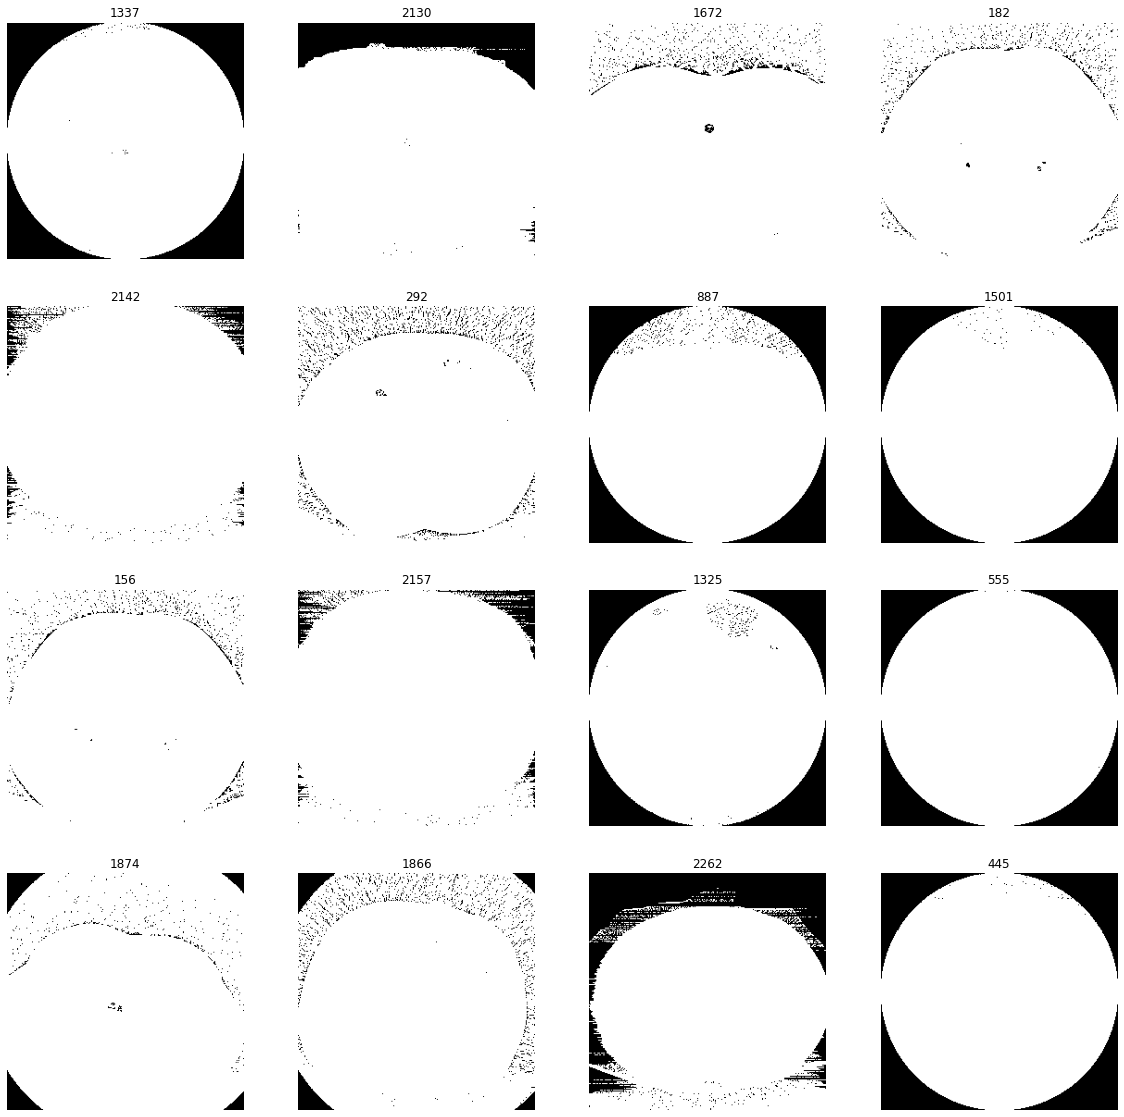

In [7]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

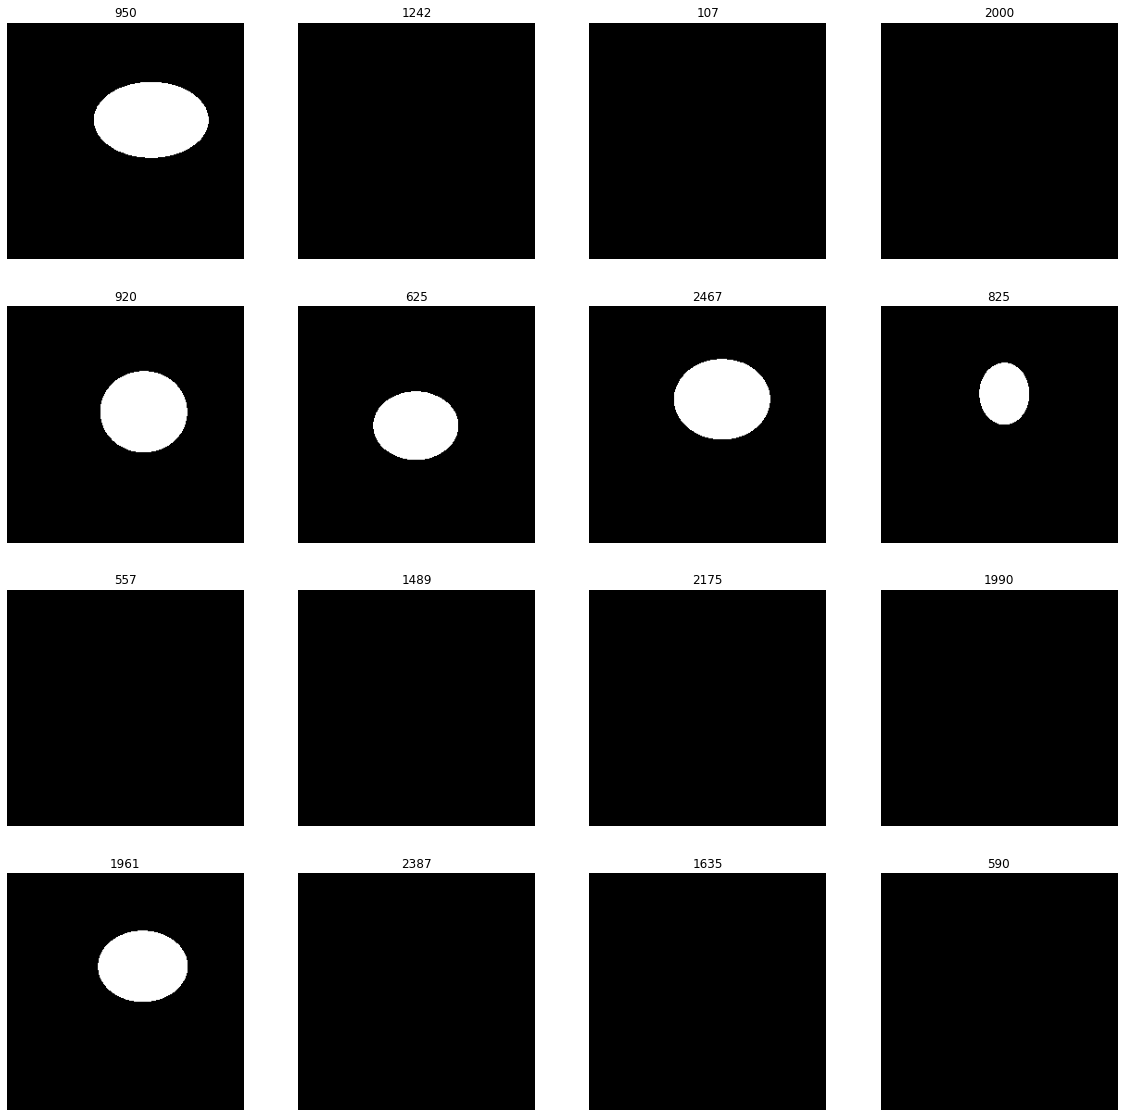

In [8]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [9]:
!pip install pydicom

In [10]:
import pydicom as dicom
from pydicom.data import get_testdata_file
#plt.imshow(pixel_array_numpy,cmap=plt.cm.bone)

In [11]:
TRAIN_PATH ='../input/ct-heart-segmentation/data/test/'
X_test=[]
for folder in tqdm(os.listdir(TRAIN_PATH)):
    files=gb.glob(TRAIN_PATH+folder+'/'+str(os.listdir(TRAIN_PATH+'/'+folder)[0])+'/*.dcm')
    for file in files :
        ds = dicom.dcmread(file)
        img = ds.pixel_array
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        X_test.append(list(img))

100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


In [12]:
X_test=np.array(X_test)

In [13]:
X_test=np.stack((X_test,)*3,axis=-1)
X_test.shape

(832, 256, 256, 3)

In [14]:
X_test=X_test.astype(np.float32)

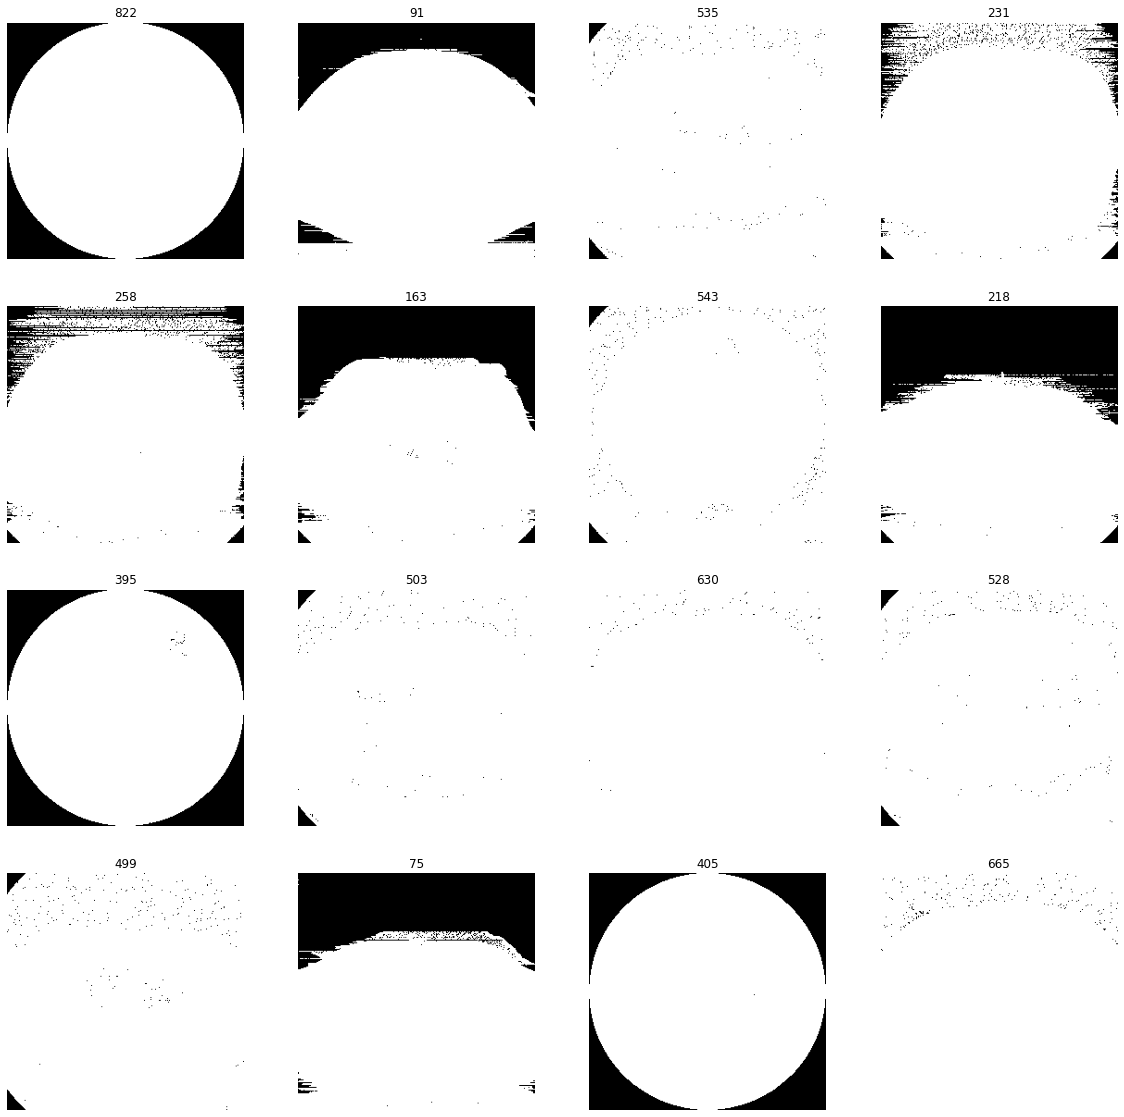

In [15]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_test[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [16]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [17]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb2'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet')
#plot_model(model)

31940608/31936256 [==============================] - 1s 0us/step


In [18]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('heart_segmentation-model.h5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [19]:
model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.iou_score,sm.metrics.FScore(threshold=0.5)])

In [20]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=2,steps_per_epoch=len(X_train)//32,epochs=20,
                 callbacks=callback,verbose=1)

Epoch 1/20
79/79 [==============================] - 266s 3s/step - loss: 0.8210 - recall: 0.7936 - precision: 0.1859 - auc: 0.8878 - iou_score: 0.1130 - f1-score: 0.2912 - val_loss: 0.9268 - val_recall: 1.0000 - val_precision: 0.0421 - val_auc: 0.8162 - val_iou_score: 0.0396 - val_f1-score: 0.0793

Epoch 00001: val_loss improved from inf to 0.92679, saving model to heart_segmentation-model.h5
Epoch 2/20
79/79 [==============================] - 242s 3s/step - loss: 0.6292 - recall: 0.7800 - precision: 0.3871 - auc: 0.8760 - iou_score: 0.3102 - f1-score: 0.3933 - val_loss: 0.8412 - val_recall: 0.9945 - val_precision: 0.1044 - val_auc: 0.9159 - val_iou_score: 0.0940 - val_f1-score: 0.1624

Epoch 00002: val_loss improved from 0.92679 to 0.84115, saving model to heart_segmentation-model.h5
Epoch 3/20
79/79 [==============================] - 246s 3s/step - loss: 0.5732 - recall: 0.8330 - precision: 0.4252 - auc: 0.9230 - iou_score: 0.3719 - f1-score: 0.4353 - val_loss: 0.6333 - val_recall: 0

In [21]:
y_pred=model.predict(X_train)

In [22]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

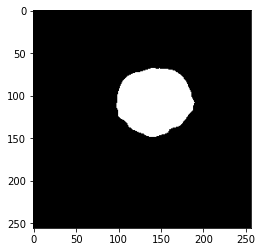

In [23]:
plt.imshow(y_pred_p[0],cmap='gray')

(-0.5, 255.5, 255.5, -0.5)

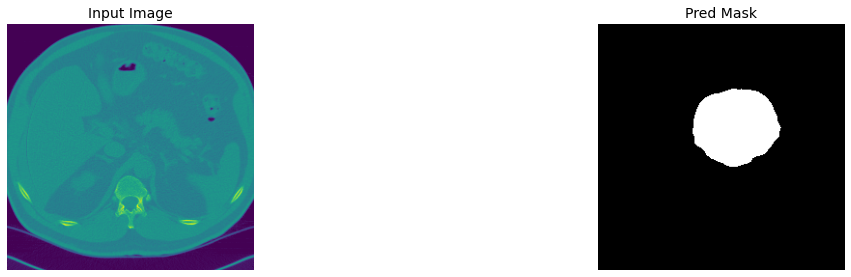

In [24]:
plt.figure(figsize=(15,15))
plt.axis('Off')
test_image = X_test[0, :, :, 0]
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Input Image', fontsize=14)
plt.axis('off')


test_mask = y_pred_p[0, :, :, 0]
plt.subplot(1,3,3)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')